In [1]:
#@title Install arviz
!pip3 install arviz

In [2]:
import arviz as az
import pystan
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

%matplotlib inline

# Model 1 

S: susceptible
I: infected
U: unknown cases
C: identified cases
R: recovered cases
D: dead cases


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


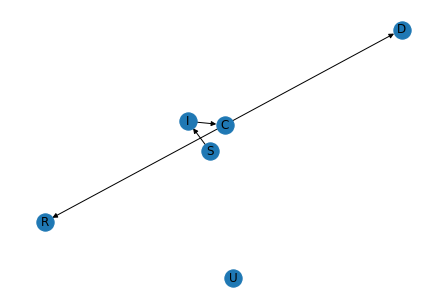

In [3]:
print("S: susceptible")
print("I: infected")
print("U: unknown cases")
print("C: identified cases")
print("R: recovered cases")
print("D: dead cases")


G = nx.DiGraph()
G.add_node('S')
G.add_node('I')
G.add_node('C')
G.add_node('R')
G.add_node('D')
G.add_node('U')
G.add_edges_from([('S','I'),('I','C'),('C','R'),('C','D')])
nx.draw(G,with_labels=True)


\begin{eqnarray}
\frac{dC}{dt} &=& \sigma_c I - \gamma_r C - \gamma_d C &\qquad\qquad &  \frac{dD}{dt} &=& \gamma_d C\\
\frac{dR}{dt} &=& \gamma_r C &\qquad\qquad & \frac{dI}{dt} &=& \beta I (1-Z) - \sigma_c I - \sigma_r I \\
\frac{dZ}{dt} &=& \beta I (1-Z)  &\qquad\qquad & \frac{dU}{dt} &=& \sigma_r I
\end{eqnarray}

In [4]:
mbs_model1_code = """
functions {
  real[] SIR(real t,  // time
                real[] y,           // system state {infected,cases,susceptible}
                real[] theta,       // parameters 
                real[] x_r,
                int[] x_i)
    {
        real dy_dt[6];

        real sigmac = theta[1];
        real gammar = theta[2];
        real gammad =  theta[3];
        real beta = theta[4]; 
        real sigmar = theta[5];
        real I = y[1];  # infected
        real C = y[2];  # cases
        real Z = y[3];  # susceptible

        dy_dt[1] = sigmac*I - gammar*C - gammad*C; //dC
        dy_dt[2] = gammad*C; //dD
        dy_dt[3] = gammar*C; //dR
        dy_dt[4] = beta*I*(1-Z) - sigmac*I - sigmar*I; //dI
        dy_dt[5] = beta*I*(1-Z); //dZ, Carson rewrite for S
        dy_dt[6] = sigmar*I; //dU
        return dy_dt;
    }
}

data {
    int<lower = 1> n_obs;       // number of days observed
    int<lower = 1> n_theta;     // number of model parameters
    int<lower = 1> n_difeq;     // number of differential equations for yhat
    int<lower = 1> n_ostates;     // number of observed states
    int<lower = 1> n_pop;       // population 
    int y[n_obs,n_ostates];           // data, per-day-tally [cases, deaths, recovered]
    real mut0;                // prior mean for initial time point 
    real ts[n_obs];         // time points that were observed
}

transformed data {
    real x_r[0];
    int x_i[0];
}

parameters {
    real<lower = 0> theta[n_theta]; // model parameters 
    real<lower = 0, upper = 1> S0;  // initial fraction of susceptible individuals
    real t0; // start date for epidemic (local spread), in days relative to data day indices, can be negative
}

transformed parameters{
    real y_hat[n_obs, n_difeq]; // solution from the ODE solver
    real y_init[3];     // initial conditions for fractions

    // yhat for model is larger than y observed
    // also y initialized are not the same as y observed
    // y observed are cases (C), recovered (R), and deaths (D)
    // y init are latent infected (I), cases (C), and latent susceptible (S)

    y_init[1] = 1/n_pop; //I, ODE system assumes fractional quantities ?
    y_init[2] = 0; //C
    y_init[3] = S0; //S

    y_hat = integrate_ode_rk45(SIR, y_init, t0, ts, theta, x_r, x_i);
}

model {
    real lambda[n_obs,3]; //poisson parameter [cases, deaths, recovered]

    //priors
    S0 ~ beta(2, 2); //some prior for between 0 and 1 fraction of the population
    for (i in 1:n_theta){
        theta[i] ~ lognormal(0,1);
    }

    // prior on ODE parameters left out, below are some examples from Anastasia Chatzilena
    // theta[1] ~ lognormal(0,1);
    // theta[2] ~ gamma(0.004,0.02);  //Assume mean infectious period = 5 days 


    //likelihood
    for (i in 1:n_obs){
        lambda[i,1] = y_hat[i,1]*n_pop; //convert to counts (ODE is normalized ?) [lambda cases:1, lambda deaths:2, lambda recovered:3]
        lambda[i,2] = y_hat[i,2]*n_pop;
        lambda[i,3] = y_hat[i,3]*n_pop;

        target += poisson_lpmf(y[i,1]|lambda[i,1]);  # cases
        target += poisson_lpmf(y[i,2]|lambda[i,2]);  # deaths
        target += poisson_lpmf(y[i,3]|lambda[i,3]);  # recovered

        //y[i,1] ~ poisson(lambda[i,1]);
        //y[i,2] ~ poisson(lambda[i,2]);
        //y[i,3] ~ poisson(lambda[i,3]);
    }

}
 
generated quantities {
    real R_0;      // Basic reproduction number
    R_0 = theta[4]/(theta[1]+theta[5]);
}
"""


# MBS Model 2

S: susceptible
I: infected
C: identified cases
R: recovered
D: dead


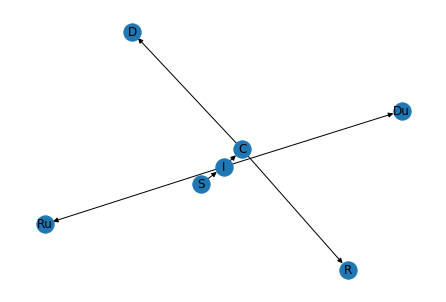

In [6]:
print("S: susceptible")
print("I: infected")
print("C: identified cases")
print("R: recovered")
print("D: dead")




G = nx.DiGraph()
G.add_node('S')
G.add_node('I')
G.add_node('C')
G.add_node('R')
G.add_node('D')
G.add_node('Ru')
G.add_node('Du')
G.add_edges_from([('S','I'),('I','C'),('I','Ru'),('I','Du'),('C','R'),('C','D')])
nx.draw(G,with_labels=True)

\begin{eqnarray}
\frac{dC}{dt} &=& \sigma_c I - (\sigma_r + \sigma_d) C &\qquad\qquad &  
\frac{dD}{dt} &=& \sigma_d C\\
\frac{dR}{dt} &=& \sigma_r C &\qquad\qquad & 
\frac{dI}{dt} &=& \beta (I+qC) (1-Z) - (\sigma_c  + \sigma_r + \sigma_d) I \\
\frac{dZ}{dt} &=& \beta (I+qC) (1-Z)  &\qquad\qquad & 
\end{eqnarray}

In [7]:
mbs_model2_code = """
functions {
  real[] SIR(real t,  // time
  real[] y,           // system state {infected,cases,susceptible}
  real[] theta,       // parameters 
  real[] x_r,
  int[] x_i) {
  
  real dy_dt[5];

  real sigmac = theta[1];
  real sigmar = theta[2];
  real sigmad =  theta[3];
  real beta = theta[4]; 
  real q = theta[5]; 
  
  real I = y[1];  # infected
  real C = y[2];  # cases
  real Z = y[3];  # susceptible
 

    dy_dt[1] = sigmac*I - (sigmar + sigmad)*C; //dC  
	dy_dt[2] = sigmad*C; //dD 
	dy_dt[3] = sigmar*C; //dR  
	dy_dt[4] = beta*(I+q*C)*(1-Z) - (sigmac + sigmar + sigmad)*I; //dI 
	dy_dt[5] = beta*(I+q*C)*(1-Z); //dZ 

  return dy_dt;
  }
}

data {
  int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations for yhat
  int<lower = 1> n_ostates;     // number of observed states
  int<lower = 1> n_pop;       // population 
  int y[n_obs,n_ostates];           // data, per-day-tally [cases, deaths, recovered]
  real t0;                // initial time point 
  real ts[n_obs];         // time points that were observed
}

transformed data {
    real x_r[0];
    int x_i[0];
}

parameters {
    real<lower = 0> theta[n_theta]; // model parameters 
    real<lower = 0, upper = 1> S0;  // initial fraction of susceptible individuals
}
  
transformed parameters{
    real y_hat[n_obs, n_difeq]; // solution from the ODE solver
    real y_init[5];     // initial conditions for fractions

    // yhat for model is larger than y observed
    // also y initialized are not the same as y observed
    // y observed are cases (C), recovered (R), and deaths (D)
    // y init are latent infected (I), cases (C), and latent susceptible (S)

    y_init[1] = 1/n_pop; //I, ccc has other formulation
    //y_init[1] = S0/n_pop + (theta[2]+theta[3])/theta[1]*log(1-S0/n_pop) + 1/n_pop;
    y_init[2] = 0; //C
    y_init[3] = S0; //S
    y_init[4] = 0; // dummy
    y_init[5] = 0; // dummy

    y_hat = integrate_ode_rk45(SIR, y_init, t0, ts, theta, x_r, x_i);

}

model {
    real lambda[n_obs,3]; //poisson parameter [cases, deaths, recovered]

    //priors
    S0 ~ beta(2, 2); //some prior for between 0 and 1 fraction of the population
    for (i in 1:n_theta){
        theta[i] ~ lognormal(0,1);
    }

    // prior on ODE parameters left out, below are some examples from Anastasia Chatzilena
    // theta[1] ~ lognormal(0,1);
    // theta[2] ~ gamma(0.004,0.02);  //Assume mean infectious period = 5 days 


    //likelihood
    for (i in 1:n_obs){
        lambda[i,1] = y_hat[i,1]*n_pop; //convert to counts (ODE is normalized ?) [lambda cases:1, lambda deaths:2, lambda recovered:3]
        lambda[i,2] = y_hat[i,2]*n_pop;
        lambda[i,3] = y_hat[i,3]*n_pop;

        target += poisson_lpmf(y[i,1]|lambda[i,1]);
        target += poisson_lpmf(y[i,2]|lambda[i,2]);
        target += poisson_lpmf(y[i,3]|lambda[i,3]);

        //y[i,1] ~ poisson(lambda[i,1]);
        //y[i,2] ~ poisson(lambda[i,2]);
        //y[i,3] ~ poisson(lambda[i,3]);
    }

}
 
generated quantities {
    real R_0;      // Basic reproduction number
    R_0 = theta[4]/(theta[1]+theta[5]);
}
"""

# MBS Model 3





S: susceptible
I: infected
RD: recovered_dead


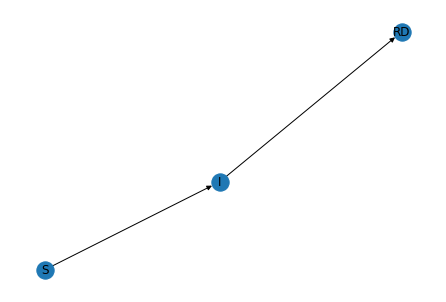

In [8]:
print("S: susceptible")
print("I: infected")
print("RD: recovered_dead")





G = nx.DiGraph()
G.add_node('S')
G.add_node('I')
G.add_node('RD')

G.add_edges_from([('S','I'),('I','RD')])
nx.draw(G,with_labels=True)

In [9]:
mbs_model3_code = """
functions {
  real[] SIR(real t,  // time
  real[] y,           // system state {susceptible, infected, recovered}
  real[] theta,       // parameters 
  real[] x_r,
  int[] x_i) {
  
  real dy_dt[3];

  real beta = theta[1];
  real gamma = theta[2];
  
  real S = y[1];  # susceptible
  real I = y[2];  # infected
  real R = y[3];  # recovered
  
  dy_dt[1] = -beta*S*I; //dS  
	dy_dt[2] = beta*S*I - gamma*I; //dI
	dy_dt[3] = gamma*I; //dR  

  return dy_dt;
  }
}

data {
  int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations for yhat
  int<lower = 1> n_ostates;     // number of observed states
  int<lower = 1> n_pop;       // population 
  int y[n_obs,n_ostates];           // data, per-day-tally [cases, deaths, recovered]
  real t0;                // initial time point 
  real ts[n_obs];         // time points that were observed
}

transformed data {
    int recovered_death[n_obs,1];
    real x_r[0];
    int x_i[0];
    
    for (i in 1:n_obs){
        recovered_death[i,1] = y[i,2] + y[i,3]; 
    }
}

parameters {
    real<lower = 0> theta[n_theta]; // model parameters 
    real<lower = 0, upper = 1> S0;  // initial fraction of susceptible individuals
}
  
transformed parameters{
    real y_hat[n_obs, n_difeq]; // solution from the ODE solver
    real y_init[3];     // initial conditions for fractions

    // yhat for model is larger than y observed
    // also y initialized are not the same as y observed
    // y observed are cases (C), recovered (R), and deaths (D)
    // y init are latent infected (I), cases (C), and latent susceptible (S)

    y_init[1] = S0; //S
    y_init[2] = 1-S0; //I
    y_init[3] = 0; //R

    y_hat = integrate_ode_rk45(SIR, y_init, t0, ts, theta, x_r, x_i);

}

model {
    real lambda[n_obs,2]; //poisson parameter [cases, recovered_dead]
    
    //priors
    S0 ~ beta(2, 2); //some prior for between 0 and 1 fraction of the population
    for (i in 1:n_theta){
        theta[i] ~ lognormal(0,1);
    }

    // prior on ODE parameters left out, below are some examples from Anastasia Chatzilena
    // theta[1] ~ lognormal(0,1);
    // theta[2] ~ gamma(0.004,0.02);  //Assume mean infectious period = 5 days 


    //likelihood
    for (i in 1:n_obs){
        lambda[i,1] = y_hat[i,1]*n_pop; //convert to counts (ODE is normalized ?) [lambda cases:1, lambda deaths:2, lambda recovered:3]
        lambda[i,2] = y_hat[i,3]*n_pop;

        
        //target += poisson_lpmf(y[i,1]|lambda[i,1]);
        //target += poisson_lpmf(recovered_death[i,1]|lambda[i,2]);
    }
    y[:,1] ~ poisson(lambda[:,1]);
    recovered_death[:,1] ~ poisson(lambda[:,2]);
}
 
generated quantities {
    real R_0;      // Basic reproduction number
    R_0 = theta[1]/theta[2];
}
"""

In [10]:
mbs_model3b_code = """
functions {
  real[] SIR(real t,  // time
  real[] y,           // system state {susceptible,infected,recovered}
  real[] theta,       // parameters
  real[] x_r,
  int[] x_i) {
  
  real dy_dt[3];
  
  dy_dt[1] = - theta[1] * y[1] * y[2];
  dy_dt[2] = theta[1] * y[1] * y[2] - theta[2] * y[2];
  dy_dt[3] = theta[2] * y[2];
  
  return dy_dt;
  }
  
  }
  data {
  int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations
  int<lower = 1> n_pop;       // population 
  int y[n_obs];           // data, total number of infected individuals each day
  real t0;                // initial time point (zero)
  real ts[n_obs];         // time points observed
  }
  
  transformed data {
  real x_r[0];
  int x_i[0];
  }
  
  parameters {
  real<lower = 0> theta[n_theta]; // model parameters {beta,gamma}
  real<lower = 0, upper = 1> S0;  // initial fraction of susceptible individuals
  }
  
  transformed parameters{
  real y_hat[n_obs, n_difeq]; // solution from the ODE solver
  real y_init[n_difeq];     // initial conditions for both fractions of S and I
  
  y_init[1] = S0;
  y_init[2] = 1 - S0;
  y_init[3] = 0;
  y_hat = integrate_ode_rk45(SIR, y_init, t0, ts, theta, x_r, x_i);
  
  }
  
  model {
  real lambda[n_obs];      //poisson parameter
  
  //priors
  theta[1] ~ lognormal(0,1);
  theta[2] ~ gamma(0.004,0.02);  //Assume mean infectious period = 5 days 
  S0 ~ beta(0.5, 0.5);
  
  //likelihood
  for (i in 1:n_obs){
  lambda[i] = y_hat[i,2]*n_pop;
  }
  y ~ poisson(lambda);
  }
  
  generated quantities {
  real R_0;      // Basic reproduction number
  R_0 = theta[1]/theta[2];
  }
"""

In [11]:
mbs_model3c_code = """
functions {
  real[] SIR(real t,  // time
  real[] y,           // system state {susceptible, infected, recovered}
  real[] theta,       // parameters 
  real[] x_r,
  int[] x_i) {
  
  real dy_dt[3];

  real beta = theta[1];
  real gamma = theta[2];
  
  real S = y[1];  # susceptible
  real I = y[2];  # infected
  real R = y[3];  # recovered
  
  dy_dt[1] = -beta*S*I; //dS  
  dy_dt[2] = beta*S*I - gamma*I; //dI
  dy_dt[3] = gamma*I; //dR  

  return dy_dt;
  }
}

data {
  int<lower = 1> n_obs;       // number of days observed
  int<lower = 1> n_theta;     // number of model parameters
  int<lower = 1> n_difeq;     // number of differential equations for yhat
  int<lower = 1> n_ostates;     // number of observed states
  int<lower = 1> n_pop;       // population 
  int y[n_obs,n_ostates];           // data, per-day-tally [cases]
  real t0;                // initial time point 
  real ts[n_obs];         // time points that were observed
}

transformed data {
  real x_r[0];
  int x_i[0];
  }
  
parameters {
    real<lower = 0> theta[n_theta]; // model parameters 
    real<lower = 0, upper = 1> S0;  // initial fraction of susceptible individuals
}
  
transformed parameters{
    real y_hat[n_obs, n_difeq]; // solution from the ODE solver
    real y_init[n_difeq];     // initial conditions for fractions

    y_init[1] = S0; //S
    y_init[2] = 1-S0; //I
    y_init[3] = 0; //R

    y_hat = integrate_ode_rk45(SIR, y_init, t0, ts, theta, x_r, x_i);

}
  
model {
    real lambda[n_obs]; //poisson parameter [cases, recovered_dead]

    //priors
    S0 ~ beta(2, 2); //some prior for between 0 and 1 fraction of the population
    //for (i in 1:n_theta){
    //    theta[i] ~ lognormal(0,1);
    //}

    // prior on ODE parameters left out, below are some examples from Anastasia Chatzilena
    theta[1] ~ lognormal(0,1);
    theta[2] ~ gamma(0.004,0.02);  //Assume mean infectious period = 5 days 


    //likelihood
    for (i in 1:n_obs){
        lambda[i] = y_hat[i,2]*n_pop;
        //target += poisson_lpmf(y[i]|lambda[i]);
        }
        y[:,1] ~ poisson(lambda);
}
  
  generated quantities {
  real R_0;      // Basic reproduction number
  R_0 = theta[1]/theta[2];
  }
"""

## Select and compile model

In [55]:
import MBS_epidemic_concentration_models as models
mbsmodel = pystan.StanModel(model_code=models.model1().stan)
# mbsmodel = pystan.StanModel(model_code=mbs_model3_code)#,verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3546012605c544f2fa3caecba882fb18 NOW.


In [56]:
#this needs to match the model code used
# stan_data = {
# 'n_theta':5,
# 'n_difeq':5,
# 'n_ostates':3
# }

stan_data = {
'n_theta':2,
'n_difeq':3,
'n_ostates':3
}




## Load data from JHU



In [57]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

dfc = pd.read_csv(url_confirmed)
dfd = pd.read_csv(url_deaths)
dfr = pd.read_csv(url_recovered)




## Make roi DF

In [58]:
roi = "Italy"

dates = dfc.columns[4:].values

dfc2 = dfc.loc[dfc['Country/Region']==roi]
dfd2 = dfd.loc[dfd['Country/Region']==roi]
dfr2 = dfr.loc[dfr['Country/Region']==roi]


DF = df = pd.DataFrame(columns=['date','cases','recovered','deaths'])


for i in range(len(dates)):
  DF.loc[i] = pd.Series({'date':dates[i],
                         'cases':dfc2[dates[i]].values[0] - (dfr2[dates[i]].values[0] + dfd2[dates[i]].values[0]),
                         'recovered':dfr2[dates[i]].values[0],
                         'deaths':dfd2[dates[i]].values[0]})


pop = {}
pop['Italy'] = 60500000
pop['United Kingdom'] = 6440000



## Format data for Stan

t0 assumed to be: day 9
{'n_theta': 2, 'n_difeq': 3, 'n_ostates': 3, 't0': 8, 'n_pop': 1000, 'ts': array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]), 'y': array([[    2,     0,     0],
       [    2,     0,     0],
       [    2,     0,     0],
       [    2,     0,     0],
       [    2,     0,     0],
       [    2,     0,     0],
       [    2,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,     0,     0],
       [    3,    

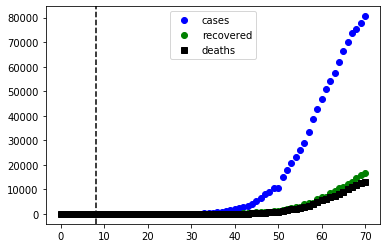

In [59]:
# data {
#   int<lower = 1> n_obs;       // number of days observed
#   int<lower = 1> n_theta;     // number of model parameters
#   int<lower = 1> n_difeq;     // number of differential equations for yhat
#   int<lower = 1> n_ostates;     // number of observed states
#   int<lower = 1> n_pop;       // population 
#   int y[n_obs,n_ostates];           // data, per-day-tally [cases, deaths, recovered]
#   real t0;                // prior mean for initial time point 
#   real ts[n_obs];         // time points that were observed
# }

t0 = np.where(DF["cases"].values>=1)[0][0]# estimated day of first exposure? Need to make this a parameter

stan_data['t0'] = t0-1

stan_data['n_pop'] = 1000#pop[roi] 
stan_data['ts'] = np.arange(t0,len(dates))  
stan_data['y'] = (DF[['cases','recovered','deaths']].to_numpy()).astype(int)[t0:,:]
stan_data['n_obs'] = len(dates) - t0

print("t0 assumed to be: day "+str(t0))
plt.plot(DF["cases"],'bo', label="cases")
plt.plot(DF["recovered"],'go',label="recovered")
plt.plot(DF["deaths"],'ks',label="deaths")

plt.axvline(stan_data['t0'],color='k', linestyle="dashed")
plt.legend()

print(stan_data)





In [16]:
# #England 1978 influenza
# cases = [0,8,26,76,225,298,258,233,189,128,150,85,14,4]
# recovered = [0,0,0,0,9,17,105,162,176,166,150,85,47,20]
# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")
# pop = 763
# stan_data['t0'] = 0
# stan_data['n_pop'] = pop 
# stan_data['ts'] = np.arange(1,len(cases)+1)  
# Y = np.hstack([np.c_[cases],np.c_[recovered],np.zeros((len(cases),1))]).astype(int)
# stan_data['y'] = Y
# stan_data['n_obs'] = len(cases)



## Run Stan 

In [60]:
# Feed in some feasible initial values to start from

# init_par = [{'theta':[0.25,0.01,0.01,0.05,.02],'S0':0.5}] 

init_par = [{'theta':[2.5,0.3],'S0':0.9}] 


In [61]:
# control = {'adapt_delta':0.9}
# fit = model.sampling(data = dat,chains = 1,iter=2000, warmup=1000, init = [init], pars = pars,control=control)#,algorithm = "Fixed_param")
# fit = sm.sampling(data=stan_data, iter=1000, chains=4)


# parameters {
#   real<lower = 0> theta[n_theta]; // model parameters 
#   real<lower = 0, upper = 1> S0;  // initial fraction of susceptible individuals
#   real t0; // start date for epidemic (local spread), in days relative to data day indices, can be negative
# }

control = {'adapt_delta':0.9}
fit = mbsmodel.sampling(data = stan_data,chains = 1,iter=2000, warmup=1000, init = init_par,control=control)

In [62]:
print(fit)

Inference for Stan model: anon_model_3546012605c544f2fa3caecba882fb18.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    1.0e-3  1.6e-5 3.6e-4 5.0e-4 7.8e-4 1.0e-3 1.2e-3 1.9e-3    496    1.0
theta[2]      0.14  7.6e-5 1.6e-3   0.13   0.14   0.14   0.14   0.14    424    1.0
S0            0.78  2.6e-5 5.9e-4   0.78   0.78   0.78   0.78   0.78    501    1.0
y_hat[1,1]    0.78  2.4e-5 5.5e-4   0.78   0.78   0.78   0.78   0.78    514    1.0
y_hat[2,1]    0.78  2.2e-5 5.1e-4   0.78   0.78   0.78   0.78   0.78    529    1.0
y_hat[3,1]    0.78  2.0e-5 4.8e-4   0.78   0.78   0.78   0.78   0.78    546    1.0
y_hat[4,1]    0.78  1.9e-5 4.5e-4   0.78   0.78   0.78   0.78   0.78    567    1.0
y_hat[5,1]    0.78  1.8e-5 4.3e-4   0.78   0.78   0.78   0.78   0.78    589    1.0
y_hat[6,1]    0.78  1.7e-5 4.2e-4   0.78   0.78   0.78   0.78   

array([<matplotlib.axes._subplots.AxesSubplot object at 0x143c13050>,
      dtype=object)

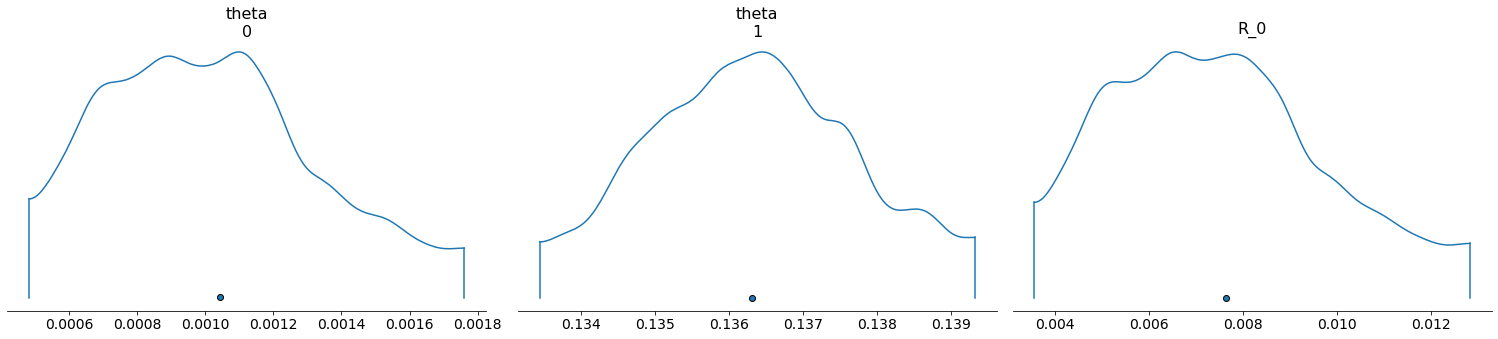

In [63]:
#https://arviz-devs.github.io/arviz/generated/arviz.plot_density
az.plot_density(fit,group='posterior',var_names=["theta","R_0"])